# Goal
Determine the optimal net height and camera aperture setting to maximize tag scanability in the presence of a physical barrier (the net) between the camera and the tracking area.

This analysis was performed on two sets of data: before and after adjustment of the lens aperture. 

## Step 1: Normalise the video footage
Video footage for each net height consisted of two parts: 
- the A4 sheet with printed tags laid still
- the A4 sheet with printed tags was moved in circles

However, these parts were not consistent in length for each video. The below code aims to identify the moment of transition between the two parts. This information gets added to a dataframe holding this information for each video. 

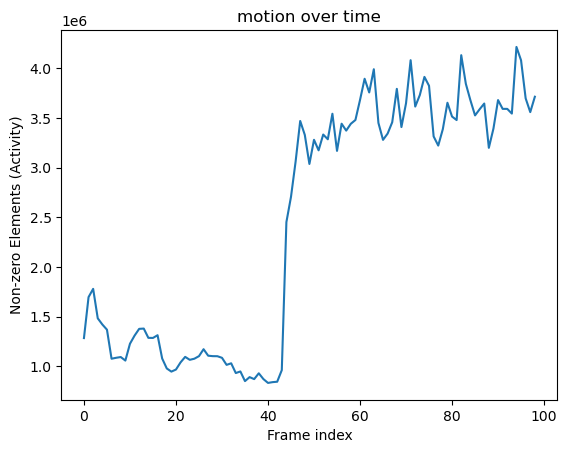

estimated switch at frame: 44


In [6]:
import numpy as np
from scipy.sparse import bsr_matrix
import matplotlib.pyplot as plt
import os

def analyze_movement(npz_path):
    data = np.load(npz_path, allow_pickle = True)
    frames = data['bsr_matrix'] 
    nnz_counts = [] #to count non-zero elements
    for bsr in frames[1:]: #all frames except frame 0
        if isinstance(bsr, bsr_matrix):
            nnz_counts.append(bsr.nnz) 
        else: #convert to bsr matrix if it is not already a bsr_matrix
            bsr = bsr_matrix(bsr)
            nnz_counts.append(bsr.nnz)
    return nnz_counts

#loop through npz files

all_nnz=[]
npz_dir = 'data/Net_height_analysis2/picam1_20250605_153905_30cm_19'
for file in sorted(os.listdir(npz_dir)):
    if file.endswith('.npz'):
        nnz=analyze_movement(os.path.join(npz_dir, file))
        all_nnz.extend(nnz)

plt.plot(all_nnz)
plt.xlabel('Frame index')
plt.ylabel('Non-zero Elements (Activity)')
plt.title('motion over time')
plt.show()

diffs = np.diff(all_nnz)
threshold = np.percentile(diffs, 99)
switch_frame = np.argmax(diffs>threshold)
print('estimated switch at frame:', switch_frame+1)

    

### Note
The above analysis measures how many non-zero elements are present in each frame. This works because the frames were captured with [Sparse Motion Capture](https://github.com/JulianKempenaers/Sparse-Motion-Capture) which only saves moving pixels. 

In [132]:
import numpy as np
from scipy.sparse import bsr_matrix
import matplotlib.pyplot as plt
import os
import pandas as pd

def analyze_movement(npz_path):
    data = np.load(npz_path, allow_pickle = True)
    frames = data['bsr_matrix'] 
    nnz_counts = [] #to count non-zero elements
    for bsr in frames[1:]: #all frames except frame 0
        if isinstance(bsr, bsr_matrix):
            nnz_counts.append(bsr.nnz) 
        else: #convert to bsr matrix if it is not already a bsr_matrix
            bsr = bsr_matrix(bsr)
            nnz_counts.append(bsr.nnz)
    return nnz_counts

base_dir = 'data/Net_height_analysis2'
results = []

for folder in sorted(os.listdir(base_dir)):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    #loop through npz files
    all_nnz=[]
    for file in sorted(os.listdir(folder_path)):
        if file.endswith('.npz'):
            nnz=analyze_movement(os.path.join(folder_path, file))
            all_nnz.extend(nnz)
    if len(all_nnz) < 2:
        continue  # skip folders without enough frames
        
    diffs = np.diff(all_nnz)
    threshold = np.percentile(diffs, 99)
    switch_idx = np.argmax(diffs>threshold)
    
    switch_frame = switch_idx + 1
    frames_before = switch_frame -1
    frames_after = len(all_nnz) - frames_before
    
    results.append({
        'folder':folder,
        'switch_frame': switch_frame,
        'frames_before':frames_before,
        'frames_after':frames_after
    })

df = pd.DataFrame(results)
df

,folder,switch_frame,frames_before,frames_after
0,picam1_20250605_153755_30cm_17,44,43,42
1,picam1_20250605_153905_30cm_19,44,43,56
2,picam1_20250605_154009_30cm_21,38,37,62
3,picam1_20250605_154101_30cm_23,1,0,99
4,picam1_20250605_154259_28cm_17,56,55,25
5,picam1_20250605_154403_28cm_19,40,39,60
6,picam1_20250605_154503_28cm_21,50,49,50
7,picam1_20250605_154601_28cm_23,45,44,55
8,picam1_20250605_154842_22cm_17,50,49,42
9,picam1_20250605_155102_22cm_19,39,38,61


## data cleaning
For one file, this method did not work. I manually looked at the video and determined the real frame during which the switch occurs. 

In [133]:
df.loc[df['folder'] == 'picam1_20250605_154101_30cm_23', ['switch_frame', 'frames_before', 'frames_after']] = [48, 47, 52]
df

,folder,switch_frame,frames_before,frames_after
0,picam1_20250605_153755_30cm_17,44,43,42
1,picam1_20250605_153905_30cm_19,44,43,56
2,picam1_20250605_154009_30cm_21,38,37,62
3,picam1_20250605_154101_30cm_23,48,47,52
4,picam1_20250605_154259_28cm_17,56,55,25
5,picam1_20250605_154403_28cm_19,40,39,60
6,picam1_20250605_154503_28cm_21,50,49,50
7,picam1_20250605_154601_28cm_23,45,44,55
8,picam1_20250605_154842_22cm_17,50,49,42
9,picam1_20250605_155102_22cm_19,39,38,61


In [134]:
frames_before = df['frames_before'].min()
frames_after = df['frames_after'].min()
frames_for_percentages = df['frames_before'].min()+df['frames_after'].min()
frames_for_percentages

np.int64(62)

So the minimum numbers of frames during the static portion of the video = 27
the minimum number of frames during the movement portion of the video = 41

We shall take 27 and 41 frames from the static and movement portions of each video to make it a fair comparison. 

# Run detections

## Step 2: run tag deteciton on the selected frames

In [138]:
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import numpy as np
import stag
import skimage.draw
import scipy
import shapely
import glob
from tqdm import tqdm
import re
import sys
import os
import cv2
import csv
from tqdm.notebook import tqdm
import time
import re
from pathlib import Path

def getOrder(x):
    try:
        return int(re.search(r'_(\d{6})_\d+frames\.npz$', x).group(1))
    except Exception as e:
        print(e)
        return 999999

#repeatable function


def search_for_stags(fnames, stag_libraries, frame_reconstruction, filename_addon, df):
    frame_pattern = re.compile(r'_(\d+)frames')
    for fname in tqdm(fnames, desc="Processing videos", unit = "video", leave=True, total =len(fnames)): #looping through the VIDEOS
        frame_count=0
        files = glob.glob(fname) # Gather .npz files for this video 
        files = sorted(files, key=getOrder) # Sort files
        # Prepare to write results to CSV
        output_file = fname.replace('/*.npz', filename_addon)
        output_rows = []
        output_rows.append(["frame", "QR_id", "x_coord", "y_coord"])

         #for determining WHICH frames to analyse so that each video uses the same number of static and moving frames
        folder_name = Path(fname).parent.name
        row = df[df['folder'] == folder_name]
        if row.empty:
            print(f"No data found for folder {folder_name})")
            continue

        switch_frame = row['switch_frame'].values[0]
        frames_before = df['frames_before'].min()
        frames_after = df['frames_after'].min()
        start_frame = switch_frame - frames_before
        end_frame = switch_frame + frames_after - 1


        # Calculate total frames from npz files for this video
        total_frames = 0
        files = sorted(glob.glob(fname), key=getOrder)
        for fn in files:
            match = frame_pattern.search(fn)
            if match:
                total_frames += int(match.group(1))
        
        # Update df with total frames for this folder
        df.loc[df['folder'] == folder_name, 'total_frames'] = total_frames
    
        #additions####################################################
        i_frames = 0
        #this is where the code decides whether the frames are within the desired frame range
        global_frame_index = i_frames + 1 #i_frames starts at 0, frame index starts at 
        start_frame = switch_frame-frames_before
        
        
        fn_n = 0
        for fn in tqdm(files, desc="Processing .npz files in video", unit = "file", leave=False): #loop through the video's npz files
            try:
                fn_n += 1
                #progress = tqdm(desc=f"Processing file {fn_n}/{len(files)}. \nFile {os.path.basename(fn)} had", unit=" frame(s)", dynamic_ncols=True, leave=True)
                npz_data = np.load(fn, allow_pickle=True)
                
                # Extract data from the .npz file
                frame_ids = npz_data['frameid']
                timestamps = npz_data['timestamp']
                bsr_matrices = npz_data['bsr_matrix']
                # Sort everything based on frame_id to ensure correct order
                sorted_indices = np.argsort(frame_ids)
                frame_ids = frame_ids[sorted_indices]
                timestamps = timestamps[sorted_indices]
                bsr_matrices = bsr_matrices[sorted_indices]
                
                 # Convert each sparse matrix to a dense image and write to video
                for i, bsr_matrix in tqdm(enumerate(bsr_matrices), total=len(bsr_matrices), desc=f"Processing Frames in .npz file ", leave=False, unit="frame"):
                
                    i_frames += 1
                    global_frame_index = i_frames
                    #if not (start_frame <= global_frame_index <= end_frame):
                        #continue
                    
                    if i_frames <=1750:
                        
                        coo = bsr_matrix.tocoo()
                        frame = np.zeros((bsr_matrix.shape[0], bsr_matrix.shape[1]), dtype=np.uint8)
                        frame[coo.row, coo.col] = coo.data.astype(np.uint8)
                        if i == 0:
                            key_frame = frame.copy()
                            image = key_frame
                        else:
                            #insert code here 
                            if frame_reconstruction:
                                key_frame_overlay = key_frame.copy()
                                key_frame_overlay[frame > 0] = frame[frame > 0] #where frame>1, add frame pixel values
                                image = key_frame_overlay
                            else:
                                image = frame.copy()
                            
                        img = 255-image #invert image for processing
                        if not (start_frame <= global_frame_index <= end_frame):
                            continue
    
                        # Detect QR codes (stags)
                        for libraryHD in stag_libraries:
                            corners, ids, _ = stag.detectMarkers(img, libraryHD)
                            if ids is None or len(ids) == 0:
                                continue
                            for j, marker in enumerate(corners):
                                marker_coords = marker[0]  # Get coordinates of the marker (shape (4, 2))
                                center = marker_coords.mean(axis=0)  # Calculate centroid (average x, y)
                                x, y = center
        
                                # Save data to rows
                                output_rows.append([i_frames, int((libraryHD)*10000+ids[j][0]), float(x), float(y)])
                                if ids.shape[1] != 1:
                                    raise ValueError(f"Unexpected ids shape: {ids.shape}")
            except Exception as e:
                print(e)
        # Write results to CSV
        with open(output_file, "w", newline="") as csvfile: 
            writer = csv.writer(csvfile)
            writer.writerows(output_rows)
    
    print(f"QR detections saved to {output_file}")

In [139]:


base_dir_path = Path(base_dir)
fnames = [str(folder / '*.npz').replace('\\', '/') for folder in base_dir_path.iterdir() if folder.is_dir()]

search_for_stags(fnames, [17, 19, 21, 23], True, '_detecting_17-23libs.csv', df)

Processing videos:   0%|          | 0/12 [00:00<?, ?video/s]

Processing .npz files in video:   0%|          | 0/1 [00:00<?, ?file/s]

Processing Frames in .npz file :   0%|          | 0/86 [00:00<?, ?frame/s]

Processing .npz files in video:   0%|          | 0/1 [00:00<?, ?file/s]

Processing Frames in .npz file :   0%|          | 0/100 [00:00<?, ?frame/s]

Processing .npz files in video:   0%|          | 0/1 [00:00<?, ?file/s]

Processing Frames in .npz file :   0%|          | 0/100 [00:00<?, ?frame/s]

Processing .npz files in video:   0%|          | 0/1 [00:00<?, ?file/s]

Processing Frames in .npz file :   0%|          | 0/100 [00:00<?, ?frame/s]

Processing .npz files in video:   0%|          | 0/1 [00:00<?, ?file/s]

Processing Frames in .npz file :   0%|          | 0/81 [00:00<?, ?frame/s]

Processing .npz files in video:   0%|          | 0/1 [00:00<?, ?file/s]

Processing Frames in .npz file :   0%|          | 0/100 [00:00<?, ?frame/s]

Processing .npz files in video:   0%|          | 0/1 [00:00<?, ?file/s]

Processing Frames in .npz file :   0%|          | 0/100 [00:00<?, ?frame/s]

Processing .npz files in video:   0%|          | 0/1 [00:00<?, ?file/s]

Processing Frames in .npz file :   0%|          | 0/100 [00:00<?, ?frame/s]

Processing .npz files in video:   0%|          | 0/1 [00:00<?, ?file/s]

Processing Frames in .npz file :   0%|          | 0/92 [00:00<?, ?frame/s]

Processing .npz files in video:   0%|          | 0/1 [00:00<?, ?file/s]

Processing Frames in .npz file :   0%|          | 0/100 [00:00<?, ?frame/s]

Processing .npz files in video:   0%|          | 0/1 [00:00<?, ?file/s]

Processing Frames in .npz file :   0%|          | 0/100 [00:00<?, ?frame/s]

Processing .npz files in video:   0%|          | 0/1 [00:00<?, ?file/s]

Processing Frames in .npz file :   0%|          | 0/100 [00:00<?, ?frame/s]

QR detections saved to data/Net_height_analysis2/picam1_20250605_155304_22cm_23_detecting_17-23libs.csv


# Step 3 generate summary csv from detection csv

In [140]:
import pandas as pd
def make_summary_table(file_path):
    mycsv = file_path
    df = pd.read_csv(mycsv)
    df = df.drop_duplicates(subset=["frame", "QR_id"])
    frame_width = 3040
    frame_height = 4056

    
    summary = df.groupby('QR_id')['frame'].count().reset_index(name='count')
    summary['detection rate (% of frames)'] = (summary['count'] / frames_for_percentages) * 100
    
    #compute mean x and y coordinates per QR_id
    summary = summary.merge(df.groupby('QR_id')['x_coord'].median().rename('mean_x_coordinate'),
                            on='QR_id',
                            how='left')
    summary = summary.merge(df.groupby('QR_id')['y_coord'].median().rename('mean_y_coordinate'),
                            on='QR_id',
                            how='left')
    # Calculate frame center
    x_center = frame_width / 2
    y_center = frame_height / 2
    
    # Calculate distance to center
    summary['distance_to_center'] = np.sqrt(
        (summary['mean_x_coordinate'] - x_center) ** 2 +
        (summary['mean_y_coordinate'] - y_center) ** 2
    )
    
    
    output_file= f'{file_path.replace('.csv','quantified.csv')}'
    
    filtered = summary.sort_values('detection rate (% of frames)', ascending=False)
    filtered.to_csv(output_file, index=False)
    

In [141]:
base_dir_path = Path(base_dir)
fnames = [str(f).replace('\\', '/') for f in base_dir_path.glob('*.csv') if not f.name.endswith('quantified.csv')]
fnames

['data/Net_height_analysis2/picam1_20250605_153755_30cm_17_detecting_17-23libs.csv',
 'data/Net_height_analysis2/picam1_20250605_153905_30cm_19_detecting_17-23libs.csv',
 'data/Net_height_analysis2/picam1_20250605_154009_30cm_21_detecting_17-23libs.csv',
 'data/Net_height_analysis2/picam1_20250605_154101_30cm_23_detecting_17-23libs.csv',
 'data/Net_height_analysis2/picam1_20250605_154259_28cm_17_detecting_17-23libs.csv',
 'data/Net_height_analysis2/picam1_20250605_154403_28cm_19_detecting_17-23libs.csv',
 'data/Net_height_analysis2/picam1_20250605_154503_28cm_21_detecting_17-23libs.csv',
 'data/Net_height_analysis2/picam1_20250605_154601_28cm_23_detecting_17-23libs.csv',
 'data/Net_height_analysis2/picam1_20250605_154842_22cm_17_detecting_17-23libs.csv',
 'data/Net_height_analysis2/picam1_20250605_155102_22cm_19_detecting_17-23libs.csv',
 'data/Net_height_analysis2/picam1_20250605_155205_22cm_21_detecting_17-23libs.csv',
 'data/Net_height_analysis2/picam1_20250605_155304_22cm_23_detect

In [142]:
#fnames = [
#    '../walkingarena/data/test_run2/picam1_20250603_173956_highnet_yes_smallbox_detecting_21-23libs.csv'
#]
for file_path in fnames:
    make_summary_table(file_path)

In [7]:
#The below tags had been identified as poorly detected tags during previous analysis.

In [143]:
#bad list:
bad_tags= [
    210009,
    190012,
    170040,
    190036,
    190005,
    190018,
    190022,
    190000,
    170055,
    170019,
    190009,
    170114,
    170105,
    170024,
    170103,
    170064,
    170120,
    170010,
    170094,
    170004,
    170034,
    170014,
    170026,
    190015,
    170076,
    170147,
    170051,
    190031,
    210011,
    170119,
    190023,
    170131,
    230005,
    170078
]

# Step 4: get average detection rate for each library and height for preliminary analysis

In [148]:
import glob
import os
import re
from pathlib import Path

def analysis_of_summaries(fname, bad_tags):
    libraryHD = int(re.search(r'cm_(\d+)_detecting', fname).group(1))
    height = int(re.search(r'_(\d+)cm_', fname).group(1))
    df = pd.read_csv(fname)
    # Filter by relevant QR_id and remove bad tags
    df = df[df['QR_id'].astype(str).str.startswith(str(libraryHD))]
    df = df[~df['QR_id'].isin(bad_tags)]
    # Calculate average detection rate
    avg_rate = df['detection rate (% of frames)'].mean()

    return pd.DataFrame([{
        'libraryHD': libraryHD,
        'height': height,
        'avg_detection_rate': avg_rate,
    }])


def build_summary_table(fnames, bad_tags):
    summary_table = pd.DataFrame()
    for fname in fnames:
        row = analysis_of_summaries(fname, bad_tags)
        summary_table = pd.concat([summary_table, row], ignore_index=True)
    return summary_table   

    

In [153]:
folder = Path(base_dir)
fnames = [str(f.as_posix()) for f in folder.glob('*quantified.csv')]

summary_table = build_summary_table(fnames, bad_tags)
summary_table



,libraryHD,height,avg_detection_rate
0,17,30,77.116935
1,19,30,72.931276
2,21,30,82.795699
3,23,30,83.870968
4,17,28,69.583080
5,19,28,63.620072
6,21,28,76.344086
7,23,28,79.032258
8,17,22,77.552753
9,19,22,67.657046


### Preliminary analisis: Visually inspect for any trends

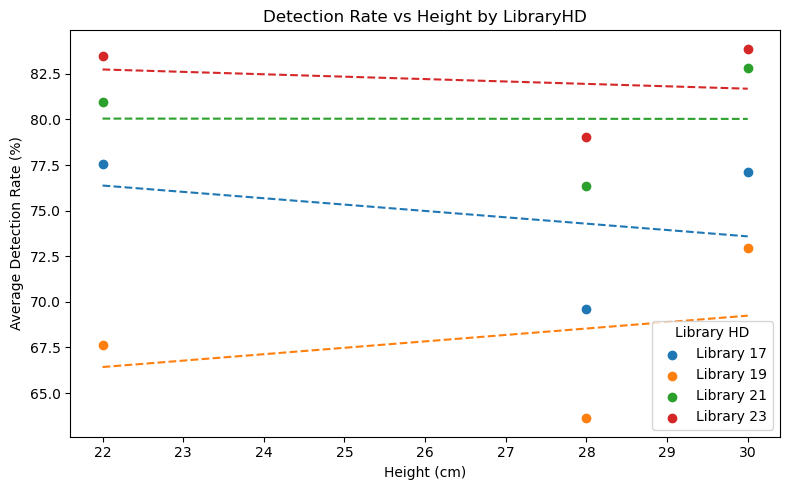

In [154]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))

for libraryHD in summary_table['libraryHD'].unique():
    subset = summary_table[summary_table['libraryHD'] == libraryHD]
    x = subset['height']
    y = subset['avg_detection_rate']
    
    ax.scatter(x, y, label=f'Library {libraryHD}')
    
    if len(x) > 1:  # Need at least 2 points for a line
        coeffs = np.polyfit(x, y, 1)  # Linear fit: y = m*x + b
        poly = np.poly1d(coeffs)
        x_fit = np.linspace(x.min(), x.max(), 100)
        y_fit = poly(x_fit)
        ax.plot(x_fit, y_fit, linestyle='--')

ax.set_xlabel('Height (cm)')
ax.set_ylabel('Average Detection Rate (%)')
ax.set_title('Detection Rate vs Height by LibraryHD')
ax.legend(title='Library HD')
plt.tight_layout()
plt.show()


### preliminary analysis: what does it look like when the lowest 50% detection rate are removed?

In [155]:
def analysis_of_summaries(fname, bad_tags):
    libraryHD = int(re.search(r'cm_(\d+)_detecting', fname).group(1))
    height = int(re.search(r'_(\d+)cm_', fname).group(1))
    df = pd.read_csv(fname)

    # Filter by relevant QR_id and remove bad tags
    df = df[df['QR_id'].astype(str).str.startswith(str(libraryHD))]
    df = df[~df['QR_id'].isin(bad_tags)]

    # Exclude detection rates below 50% before averaging
    df = df[df['detection rate (% of frames)'] >= 50]

    # Calculate average detection rate
    avg_rate = df['detection rate (% of frames)'].mean() if not df.empty else 0

    return pd.DataFrame([{
        'libraryHD': libraryHD,
        'height': height,
        'avg_detection_rate': avg_rate,
    }])

def build_summary_table(fnames, bad_tags):
    summary_table = pd.DataFrame()
    for fname in fnames:
        row = analysis_of_summaries(fname, bad_tags)
        summary_table = pd.concat([summary_table, row], ignore_index=True)
    return summary_table   

fnames = [str(f.as_posix()) for f in folder.glob('*quantified.csv')]

summary_table = build_summary_table(fnames, bad_tags)
summary_table



,libraryHD,height,avg_detection_rate
0,17,30,77.116935
1,19,30,72.931276
2,21,30,82.795699
3,23,30,83.870968
4,17,28,69.583080
5,19,28,63.620072
6,21,28,76.344086
7,23,28,79.032258
8,17,22,77.552753
9,19,22,67.657046


## Step 5: Get detection rate of each frame in preparation for violin plots

In [171]:
import glob
import os
import re
from pathlib import Path

import pandas as pd
import re

def analysis_of_summaries(fname, bad_tags):
    libraryHD = int(re.search(r'cm_(\d+)_detecting', fname).group(1))
    height = int(re.search(r'_(\d+)cm_', fname).group(1))
    df = pd.read_csv(fname)

    # Filter by relevant QR_id and remove bad tags
    df = df[df['QR_id'].astype(str).str.startswith(str(libraryHD))]
    df = df[~df['QR_id'].isin(bad_tags)]

    # Build summary for this file
    df['libraryHD'] = libraryHD
    df['height'] = height
    return df[['QR_id', 'detection rate (% of frames)', 'libraryHD', 'height']]

# Main loop
def build_summary_table(fnames, bad_tags):
    summary_table = pd.DataFrame()
    for fname in fnames:
        summary = analysis_of_summaries(fname, bad_tags)
        summary_table = pd.concat([summary_table, summary], ignore_index=True)
    return summary_table

fnames = [str(f.as_posix()) for f in folder.glob('*quantified.csv')]

summary_table = build_summary_table(fnames, bad_tags)
# Exclude detection rates below 40%
summary_table = summary_table[summary_table['detection rate (% of frames)'] >= 40]

summary_table

,QR_id,detection rate (% of frames),libraryHD,height
0,170134,98.387097,17,30
1,170138,95.161290,17,30
2,170143,95.161290,17,30
3,170117,95.161290,17,30
4,170141,93.548387,17,30
...,...,...,...,...
532,230002,98.387097,23,22
533,230004,88.709677,23,22
534,230000,74.193548,23,22
535,230001,72.580645,23,22


### Detection violin plots (excluding lowest 40%!)

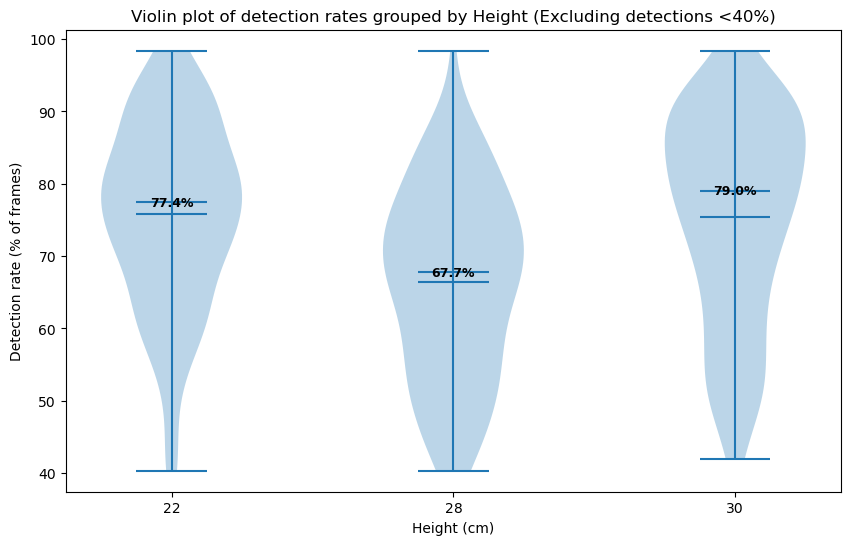

In [161]:
import numpy as np
import matplotlib.pyplot as plt

groups = summary_table.groupby('height')

fig, ax = plt.subplots(figsize=(10, 6))

data = [group['detection rate (% of frames)'].values for name, group in groups]
labels = [str(name) for name, group in groups]

parts = ax.violinplot(data, showmeans=True, showmedians=True)

ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels)
ax.set_xlabel('Height (cm)')
ax.set_ylabel('Detection rate (% of frames)')
ax.set_title('Violin plot of detection rates grouped by Height (Excluding detections <40%)')

# Add median text annotations above each violin
for i, group in enumerate(groups):
    median_val = np.median(group[1]['detection rate (% of frames)'])
    ax.text(i + 1, median_val, f'{median_val:.1f}%', ha='center', va='center', fontsize=9, fontweight='bold')


plt.show()



### Detection violin plot of all detections

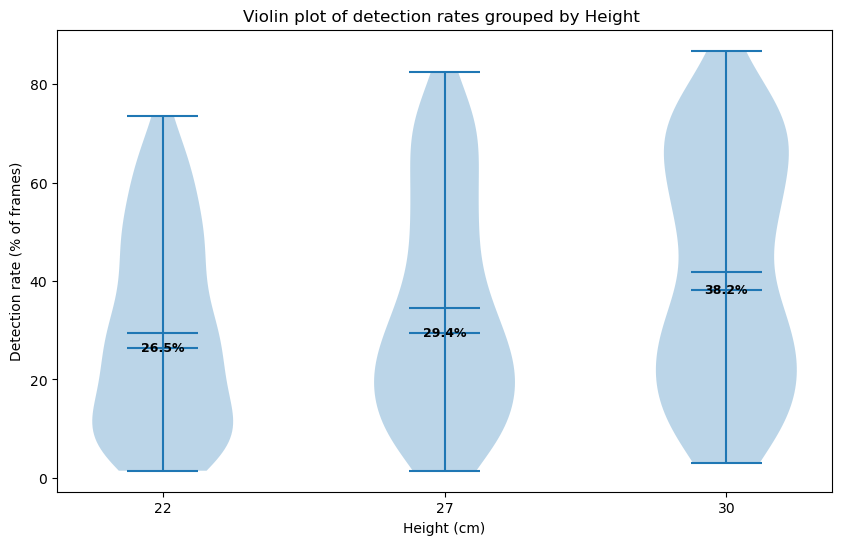

In [175]:
import glob
import os
import re
from pathlib import Path

import pandas as pd
import re

def analysis_of_summaries(fname, bad_tags):
    libraryHD = int(re.search(r'cm_(\d+)_detecting', fname).group(1))
    height = int(re.search(r'_(\d+)cm_', fname).group(1))
    df = pd.read_csv(fname)

    # Filter by relevant QR_id and remove bad tags
    df = df[df['QR_id'].astype(str).str.startswith(str(libraryHD))]
    df = df[~df['QR_id'].isin(bad_tags)]

    # Build summary for this file
    df['libraryHD'] = libraryHD
    df['height'] = height
    return df[['QR_id', 'detection rate (% of frames)', 'libraryHD', 'height']]

# Main loop
def build_summary_table(fnames, bad_tags):
    summary_table = pd.DataFrame()
    for fname in fnames:
        summary = analysis_of_summaries(fname, bad_tags)
        summary_table = pd.concat([summary_table, summary], ignore_index=True)
    return summary_table
folder = Path('data/Net_height_analysis')#########################################################################
fnames = [str(f.as_posix()) for f in folder.glob('*quantified.csv')]

summary_table = build_summary_table(fnames, bad_tags)
# Exclude detection rates below 40%

import numpy as np
import matplotlib.pyplot as plt

groups = summary_table.groupby('height')

fig, ax = plt.subplots(figsize=(10, 6))

data = [group['detection rate (% of frames)'].values for name, group in groups]
labels = [str(name) for name, group in groups]

parts = ax.violinplot(data, showmeans=True, showmedians=True)

ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels)
ax.set_xlabel('Height (cm)')
ax.set_ylabel('Detection rate (% of frames)')
ax.set_title('Violin plot of detection rates grouped by Height ')

# Add median text annotations above each violin
for i, group in enumerate(groups):
    median_val = np.median(group[1]['detection rate (% of frames)'])
    ax.text(i + 1, median_val, f'{median_val:.1f}%', ha='center', va='center', fontsize=9, fontweight='bold')


plt.show()

## Step 6: Statistical analysis
Is there a significant difference between the net heights?

Yes,  a 30cm net height has a significantly higher detection rate when compared to a net height of 28cm. 

In [166]:
from scipy.stats import kruskal

groups = [group['detection rate (% of frames)'].values for name, group in summary_table.groupby('height')]

stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H-test: H={stat:.3f}, p={p:.3f}")

if p < 0.05:
    print("Significant difference detected between groups.")
else:
    print("No significant difference between groups.")
from scipy.stats import mannwhitneyu

groups = {height: group['detection rate (% of frames)'].values
          for height, group in summary_table.groupby('height')}

# Compare 27 vs 22
stat_28_22, p_28_22 = mannwhitneyu(groups[28], groups[22], alternative='greater')
print(f"28 vs 22: U={stat_28_22}, p={p_28_22:.4f}")

# Compare 30 vs 27
stat_30_28, p_30_28 = mannwhitneyu(groups[30], groups[28], alternative='greater')
print(f"30 vs 28: U={stat_30_28}, p={p_30_28:.4f}")


Kruskal-Wallis H-test: H=45.398, p=0.000
Significant difference detected between groups.
28 vs 22: U=9504.0, p=1.0000
30 vs 28: U=20700.5, p=0.0000


## Step 7: Adding Jitter dots to visualise all data more easily

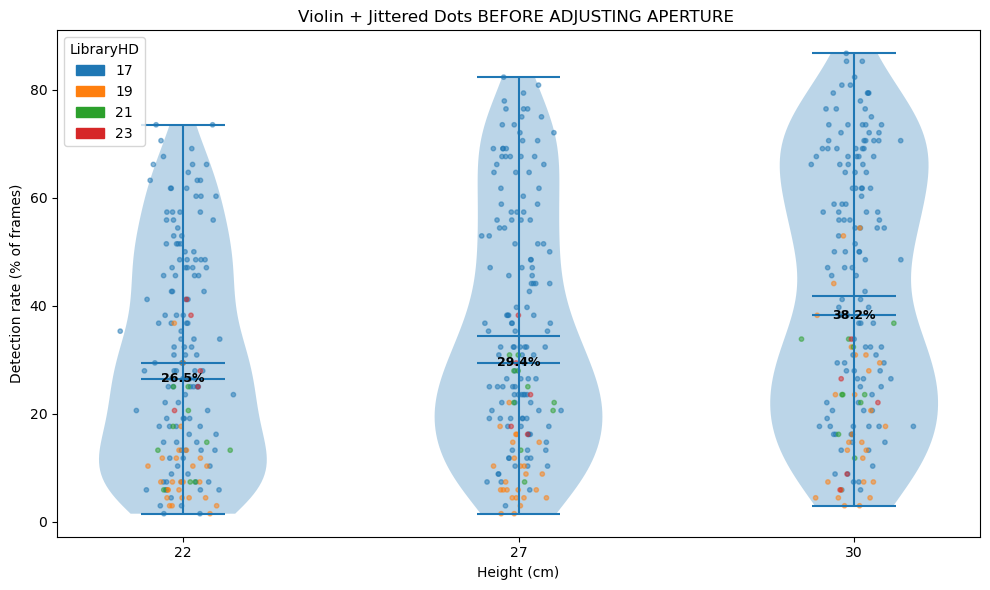

In [177]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

groups = summary_table.groupby('height')
fig, ax = plt.subplots(figsize=(10, 6))

data = [group['detection rate (% of frames)'].values for _, group in groups]
labels = [str(name) for name, _ in groups]

# Violin plot
parts = ax.violinplot(data, showmeans=True, showmedians=True)

# Jittered scatter points colored by 'libraryHD'
unique_libs = summary_table['libraryHD'].unique()
color_map = {lib: plt.cm.tab10(i) for i, lib in enumerate(unique_libs)}

for i, (height, group) in enumerate(groups):
    y = group['detection rate (% of frames)'].values
    x = np.random.normal(loc=i + 1, scale=0.05, size=len(y))
    colors = [color_map[lib] for lib in group['libraryHD']]
    ax.scatter(x, y, alpha=0.5, c=colors, s=10)

    median_val = np.median(y)
    ax.text(i + 1, median_val, f'{median_val:.1f}%', ha='center', va='center', fontsize=9, fontweight='bold')

# Axis settings
ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels)
ax.set_xlabel('Height (cm)')
ax.set_ylabel('Detection rate (% of frames)')
ax.set_title('Violin + Jittered Dots BEFORE ADJUSTING APERTURE ')


# Create legend handles
handles = [mpatches.Patch(color=color_map[lib], label=lib) for lib in unique_libs]
ax.legend(handles=handles, title='LibraryHD')
plt.tight_layout()
plt.show()
